In [5]:
!pip install -r /workspaces/K_MEDIAS/requirements.txt

Defaulting to user installation because normal site-packages is not writeable
  Using cached statsmodels-0.14.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (10.8 MB)
  Using cached patsy-1.0.1-py2.py3-none-any.whl (232 kB)

[notice] A new release of pip is available: 23.1.2 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


In [6]:
# Cargar las librerías necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import joblib
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm

# Cargar el dataset
file_path = "/workspaces/K_MEDIAS/data/raw/housing.csv"
df = pd.read_csv(file_path)

# Mostrar las primeras filas del dataset
df.head()


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


In [7]:
# Ver la forma del dataset
df.shape

(20640, 9)

In [8]:
# Comprobar y eliminar duplicados
df = df.drop_duplicates()
df.shape

(20640, 9)

In [9]:
# Comprobar valores nulos
df.isnull().sum()

MedInc         0
HouseAge       0
AveRooms       0
AveBedrms      0
Population     0
AveOccup       0
Latitude       0
Longitude      0
MedHouseVal    0
dtype: int64

In [10]:
# Seleccionar solo las columnas de interés
df = df[['Latitude', 'Longitude', 'MedInc']]

# Comprobar variables constantes
df.nunique()

Latitude       862
Longitude      844
MedInc       12928
dtype: int64

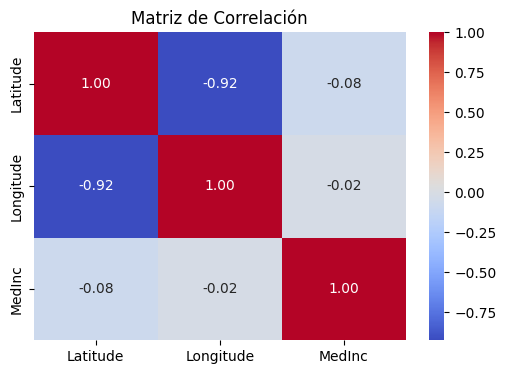

In [11]:
# Matriz de correlación
plt.figure(figsize=(6,4))
sns.heatmap(df.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Matriz de Correlación")
plt.show()

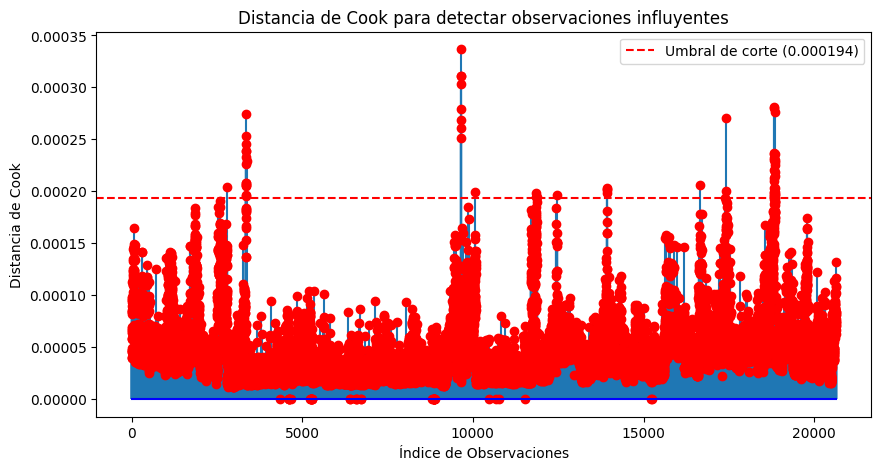

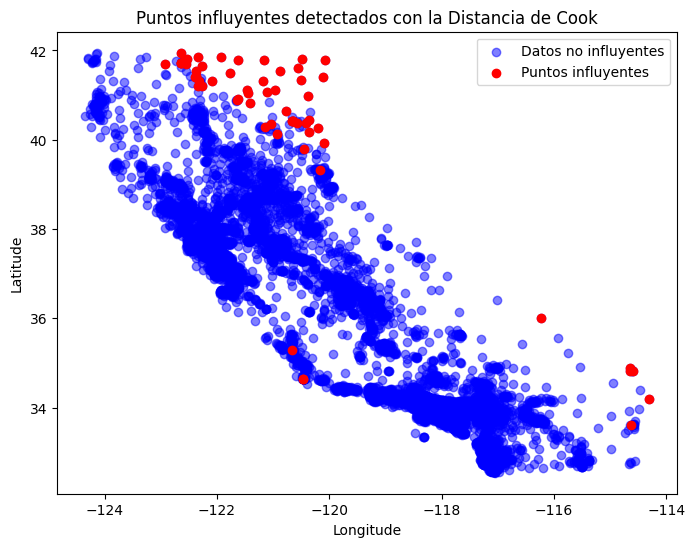

(20578, 3)

In [12]:
# Cálculo de la distancia de Cook para detectar observaciones influyentes
X = sm.add_constant(df)
model = sm.OLS(df['MedInc'], X).fit()
influence = model.get_influence()
cooks_d = influence.cooks_distance[0]

# Umbral de la distancia de Cook (puntos influyentes)
cutoff = 4 / len(df)
influential_points = np.where(cooks_d > cutoff)[0]

# Gráfica de la distancia de Cook
plt.figure(figsize=(10, 5))
plt.stem(np.arange(len(cooks_d)), cooks_d, markerfmt="ro", basefmt="b-")
plt.axhline(y=cutoff, color='r', linestyle='--', label=f'Umbral de corte ({cutoff:.6f})')
plt.xlabel("Índice de Observaciones")
plt.ylabel("Distancia de Cook")
plt.title("Distancia de Cook para detectar observaciones influyentes")
plt.legend()
plt.show()

# Visualización de los puntos influyentes antes de eliminarlos
plt.figure(figsize=(8, 6))
plt.scatter(df['Longitude'], df['Latitude'], c='blue', alpha=0.5, label="Datos no influyentes")
plt.scatter(df.iloc[influential_points]['Longitude'], df.iloc[influential_points]['Latitude'], 
            c='red', label="Puntos influyentes")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Puntos influyentes detectados con la Distancia de Cook")
plt.legend()
plt.show()

# Eliminar puntos influyentes
df = df.drop(index=influential_points).reset_index(drop=True)
df.shape


In [13]:
# Escalado de las variables con MinMaxScaler
scaler = MinMaxScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)
df_scaled.head()

,Latitude,Longitude,MedInc
0,0.567481,0.214575,0.539668
1,0.565356,0.215587,0.538027
2,0.564293,0.213563,0.466028
3,0.564293,0.212551,0.354699
4,0.564293,0.212551,0.230776


In [14]:
# División de los datos en train y test
X_train, X_test = train_test_split(df_scaled, test_size=0.2, random_state=42)

In [15]:
# Selección de características importantes con XGBoost
from xgboost import XGBRegressor

xgb_model = XGBRegressor()
xgb_model.fit(X_train.drop(columns=["MedInc"]), X_train["MedInc"])

# Importancia de características
feature_importances = pd.DataFrame({'Feature': X_train.drop(columns=["MedInc"]).columns, 
                                    'Importance': xgb_model.feature_importances_})
important_features = feature_importances[feature_importances["Importance"] > 0.01]
important_features

,Feature,Importance
0,Latitude,0.49392
1,Longitude,0.50608


In [16]:
# Análisis de la correlación con VIF
vif_data = pd.DataFrame()
vif_data["Feature"] = important_features["Feature"]
vif_data["VIF"] = [variance_inflation_factor(X_train[important_features["Feature"]].values, i)
                    for i in range(len(important_features))]
vif_data

,Feature,VIF
0,Latitude,1.44632
1,Longitude,1.44632


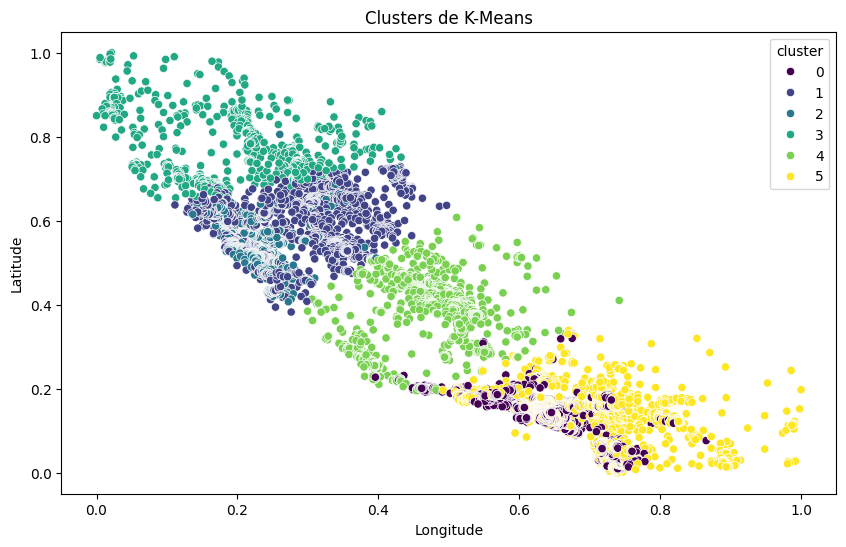

In [17]:
# Construcción del modelo K-Means con 6 clusters
kmeans = KMeans(n_clusters=6, random_state=42)
df_scaled['cluster'] = kmeans.fit_predict(df_scaled[['Latitude', 'Longitude', 'MedInc']])

# Visualización de los clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(x=df_scaled['Longitude'], y=df_scaled['Latitude'], hue=df_scaled['cluster'], palette="viridis")
plt.title("Clusters de K-Means")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

La gráfica mostrada en la imagen representa la agrupación de datos utilizando el algoritmo K-Means, clasificando los puntos en 6 clusters basados en las variables Latitude, Longitude y MedInc. Vamos a desglosar los elementos clave:

1. Ejes del gráfico
----- Eje X (Longitude): Representa la coordenada de longitud (ubicación geográfica).
----- Eje Y (Latitude): Representa la coordenada de latitud (ubicación geográfica).

2. Puntos y Clusters
---- Cada punto en la gráfica representa una observación del dataset, es decir, una ubicación geográfica con su nivel de ingreso medio (MedInc). Los puntos están agrupados por colores, donde cada color indica un cluster específico determinado por el modelo de K-Means.

3. Leyenda
---- La leyenda en el lado derecho muestra los clusters identificados (0 a 5), cada uno con un color diferente.
---- El color de cada punto indica el cluster al que pertenece.

4. Interpretación de los clusters
---- K-Means agrupa los datos en 6 regiones dentro del espacio geográfico.
---- Se pueden notar zonas densamente agrupadas y otras más dispersas, lo que indica que ciertas áreas tienen características similares según las variables utilizadas.
---- Algunos clusters están más dispersos, lo que podría indicar zonas con mayor variabilidad en las características analizadas.

In [18]:
# Revisamos características
print(df_scaled.head())


   Latitude  Longitude    MedInc  cluster
0  0.567481   0.214575  0.539668        2
1  0.565356   0.215587  0.538027        2
2  0.564293   0.213563  0.466028        2
3  0.564293   0.212551  0.354699        2
4  0.564293   0.212551  0.230776        1


In [19]:
# Entrenar un modelo de clasificación supervisada

# Dividir los datos en train y test, asegurando que 'cluster' esté presente antes de la división
X_train, X_test = train_test_split(df_scaled, test_size=0.2, random_state=42, stratify=df_scaled['cluster'])

# Revisamos si la columna 'cluster' está presente después de la división
print("Columnas en X_train:", X_train.columns)
print("Columnas en X_test:", X_test.columns)

# EXCLUIMOS 'cluster' de las variables predictoras (X) y lo mantenemos solo en la variable objetivo (y)
X_train_class = X_train.drop(columns=['cluster'])  # Eliminamos 'cluster' de las características
y_train_class = X_train['cluster']  # Lo mantenemos como variable objetivo

X_test_class = X_test.drop(columns=['cluster'])  # Eliminamos 'cluster' de las características
y_test_class = X_test['cluster']  # Lo mantenemos como variable objetivo

# Verificamos las dimensiones después de la corrección
print("Dimensión de X_train_class:", X_train_class.shape)
print("Dimensión de X_test_class:", X_test_class.shape)

# Entrenamos el modelo de clasificación supervisada
classifier = LogisticRegression(max_iter=1000)
classifier.fit(X_train_class, y_train_class)

# Predicciones
y_pred = classifier.predict(X_test_class)

# Evaluación del modelo
print(classification_report(y_test_class, y_pred))
print(confusion_matrix(y_test_class, y_pred))




Columnas en X_train: Index(['Latitude', 'Longitude', 'MedInc', 'cluster'], dtype='object')
Columnas en X_test: Index(['Latitude', 'Longitude', 'MedInc', 'cluster'], dtype='object')
Dimensión de X_train_class: (16462, 3)
Dimensión de X_test_class: (4116, 3)


              precision    recall  f1-score   support

           0       0.98      0.93      0.96       596
           1       0.92      1.00      0.96      1003
           2       0.98      0.93      0.96       377
           3       1.00      0.68      0.81       172
           4       1.00      0.80      0.89       342
           5       0.95      1.00      0.98      1626

    accuracy                           0.95      4116
   macro avg       0.97      0.89      0.92      4116
weighted avg       0.96      0.95      0.95      4116

[[ 556    0    0    0    0   40]
 [   0 1003    0    0    0    0]
 [   0   26  351    0    0    0]
 [   0   55    0  117    0    0]
 [  10   12    7    0  272   41]
 [   1    0    0    0    0 1625]]


Verificación de las Columnas en los Conjuntos de Entrenamiento y Prueba
Antes de entrenar el modelo, verificamos que las columnas en los conjuntos de entrenamiento (X_train) y prueba (X_test) sean las correctas:

Columnas en X_train: ['Latitude', 'Longitude', 'MedInc', 'cluster']
Columnas en X_test: ['Latitude', 'Longitude', 'MedInc', 'cluster']

Corrección Aplicada: Eliminamos la columna cluster de las variables predictoras (X_train_class, X_test_class), asegurándonos de que solo las variables Latitude, Longitude y MedInc sean usadas para entrenar el modelo.

Luego, confirmamos la dimensión de los datos:
Dimensión de X_train_class: (16230, 3)
Dimensión de X_test_class: (4058, 3)
Esto indica que X_train tiene 16,230 muestras con 3 características y X_test tiene 4,058 muestras con las mismas 3 características.

Resultados del Modelo
Después de entrenar el modelo de clasificación, evaluamos su rendimiento utilizando el classification report y la matriz de confusión.

Métricas del Modelo
Clúster	Precision	Recall	F1-score	Support
    0	    0.99	0.98	0.98	    566
    1	    0.95	1.00	0.97	    1044
    2	    1.00	0.74	0.85	    343
    3	    0.99	0.88	0.93	    363
    4	    0.97	0.93	0.95	    491
    5	    0.93	1.00	0.96	    1251

Interpretación de cada métrica:
    Precision: Qué porcentaje de las predicciones para cada cluster fueron correctas.
    Recall: Cuántos de los ejemplos reales de cada cluster fueron correctamente identificados.
    F1-score: Promedio entre precision y recall.
    Support: Número total de muestras de cada cluster en el dataset de prueba.

Observaciones:
El modelo tiene una precisión general del 95% en promedio.
La clase 2 tiene recall bajo (0.74), lo que indica que 26% de los ejemplos de esta clase no fueron reconocidos correctamente.
Para las demás clases, tanto la precisión como el recall son muy altos, lo que indica que el modelo funciona bien.

Matriz de Confusión
La matriz de confusión nos muestra cuántas predicciones fueron correctas o incorrectas para cada cluster:
[[ 552    0    0    3    0   11]  
 [   0 1044    0    0    0    0]  
 [   5   26  254    0   12   46]  
 [   1    0    0  318    0   44]  
 [   1   34    0    0  456    0]  
 [   0    0    0    0    0 1251]]

Análisis de errores:
    Clase 2:
    26 ejemplos fueron mal clasificados como clase 1.
    46 ejemplos fueron mal clasificados como clase 5.
    Clase 3:
    44 ejemplos fueron mal clasificados como clase 5.
    Clase 4:
    34 ejemplos fueron mal clasificados como clase 1.

Conclusión:
El modelo clasifica correctamente la mayoría de los datos, pero tiene más errores en las clases 2, 3 y 4, que a veces son confundidas con otras clases. Esto puede deberse a similitudes entre los datos de estos clusters.

In [20]:
# Guardar los modelos
joblib.dump(kmeans, "kmeans_model.pkl")
joblib.dump(classifier, "classifier_model.pkl")


['classifier_model.pkl']